Sascha Spors,
Professorship Signal Theory and Digital Signal Processing,
Institute of Communications Engineering (INT),
Faculty of Computer Science and Electrical Engineering (IEF),
University of Rostock,
Germany

# Tutorial Digital Signal Processing

**Pole/Zeros Plots of Window Functions**,
Winter Semester 2020/21 (Course #24505)

- lecture: https://github.com/spatialaudio/digital-signal-processing-lecture
- tutorial: https://github.com/spatialaudio/digital-signal-processing-exercises

Feel free to contact lecturer frank.schultz@uni-rostock.de

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from scipy.signal import tf2zpk
from scipy.signal.windows import hann, hamming, chebwin, slepian, kaiser
from numpy.fft import fft, fftshift, ifft 

In [2]:
def zplane_plot(z, p, k, title_str):
    """Plot pole/zero/gain plot of discrete-time, linear-time-invariant system.

    Note that the for-loop handling might be not very efficient
    for very long FIRs

    z...array of zeros in z-plane
    p...array of poles in z-zplane
    k...gain factor

    taken from own work
    URL = ('https://github.com/spatialaudio/signals-and-systems-exercises/'
           'blob/master/sig_sys_tools.py')

    currently we don't use the ax input parameter, we rather just plot
    in hope for getting an appropriate place for it from the calling function
    """
    # draw unit circle
    Nf = 2**7
    Om = np.arange(Nf) * 2*np.pi/Nf
    plt.plot(np.cos(Om), np.sin(Om), 'C7')

    try:  # TBD: check if this pole is compensated by a zero
        circle = Circle((0, 0), radius=np.max(np.abs(p)),
                        color='C7', alpha=0.15)
        plt.gcf().gca().add_artist(circle)
    except ValueError:
        print('no pole at all, ROC is whole z-plane')

    zu, zc = np.unique(z, return_counts=True)  # find and count unique zeros
    for zui, zci in zip(zu, zc):  # plot them individually
        plt.plot(np.real(zui), np.imag(zui), ms=7,
                 color='C0', marker='o', fillstyle='none')
        if zci > 1:  # if multiple zeros exist then indicate the count
            plt.text(np.real(zui), np.imag(zui), zci)

    pu, pc = np.unique(p, return_counts=True)  # find and count unique poles
    for pui, pci in zip(pu, pc):  # plot them individually
        plt.plot(np.real(pui), np.imag(pui), ms=7,
                 color='C3', marker='x')
        if pci > 1:  # if multiple poles exist then indicate the count
            plt.text(np.real(pui), np.imag(pui), pci)

    plt.text(0, +1, 'k=%f' % k)
    plt.text(0, -1, 'ROC for causal: white')
    plt.axis('square')
    # plt.axis([-2, 2, -2, 2])
    plt.xlabel(r'$\Re\{z\}$')
    plt.ylabel(r'$\Im\{z\}$')
    plt.title(title_str)
    plt.grid(True)
    
def freq_resp(w, label_str, Nz=2**10):
    Omega = 2*np.pi/Nz*np.arange(Nz)
    W = np.zeros(Nz)
    W[0:N] = w
    W = fftshift(fft(W))
    W /= np.max(np.abs(W))
    W = np.abs(W)
    W[W < 10**(-100/20)] = 10**(-100/20)  # avoid log10(0)
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twiny()
    ax1.plot(Omega/np.pi*180-180, 20*np.log10(W), label=label_str)
    ax1.set_xlabel(r'$\Omega$ / deg')
    ax1.set_ylabel(r'normalized $|W(\Omega)|$')
    ax1.set_xticks(np.angle(z)*180/np.pi)
    ax1.set_yticks(np.arange(-100, 10, 10))
    ax1.set_xlim(-180, 180)
    ax1.set_ylim(-100, 0)
    ax1.legend()
    ax1.grid(True, which='both')
    ax2.plot(Omega-np.pi, 20*np.log10(W))
    ax2.set_xlabel(r'$\Omega$ / rad')
    ax2.set_xlim(-np.pi, np.pi);

In [3]:
N = 8  # length of window

In [4]:
# don't change, this is needed below repeatedly:
k = np.arange(N)
a = np.zeros(N)
a[0] = 1

For a length $N$ window $w[k]$ with 
- $w[k]=0$ if $k<0$ and $k>N-1$

we have the z-transform of the window / finite length sequence

\begin{equation}
W(z) = \sum_{k=0}^{N-1} w[k] z^{-k} = w[0] + w[1] z^{-1} + w[2] z^{-2} + ... + w[N-1] z^{-(N-1)}
\end{equation}

We can rewrite 

\begin{equation}
W(z) = \frac{w[0] z^{N-1} + w[1] z^{N-2} + w[2] z^{N-3} + ... + w[N-1]}{z^{N-1}}
\end{equation}

- This rational function has $N-1$ poles in the origin, i.e. $z=0$
- Furthermore, it has $N-1$ zeros somewhere in the complex z-plane

For real valued $w[k]$ the zeros are either complex conjugate or real-valued (they lie on the real axis in the z-plane).

For the windowing process we are interested in the DTFT spectrum, which can be obtained when evaluating $W(z)$ along the unit circle, thus as

\begin{equation}
W(\Omega) = W(z)\big|_{z=\mathrm{e}^{\mathrm{j}\Omega}}
\end{equation}

Window design is about meaningful, if not to say clever, positioning of $N-1$ zeros, such that a desired trade-off
between **mainlobe width** and **sidelobe magnitude** / **sidelobe decay rate** is achieved.
Naturally, this design task has many, many solutions. Some of them are more meaningful than others, which is why they
were published as special window designs over the last decades.

For windowing we actually always aim at very low sidelobes. Thus all potential zeros of $W(z)$ should used as best as possible: putting them exactly onto the unit circle the impact is largest in the DTFT spectrum, since notches are realized. Windows that follow this design rule, are commonly termed optimum windows. The design constraints for the trade-off then tell us where exactly to put these zeros on the unit circle.

In the examples below we discuss very simple cases for rather small $N$.

**Example 1**

Although, is has worst leakage effect, the rectangular window is actually an optimum window. The design criterion is simply: provide the most narrow main lobe that is possible for $N$. The price you pay is the highest sidelobe magnitude and very slow sidelobe decay rate.

**Example 2**

This is a! symmetric Hann window (in older literature misnamed as Hanning window, don't do this anymore!). We see that two zeros are real valued and not on the unit circle. They don't shape the window spectrum in optimum manner.

Note that for didactical convenience we use a symmetric window here. For practical spectral analysis we rather should use the flag `sym=False` for scipy windows.

**Example 3**

Idea of Hamming window:
- taking the above Hann window and moving the two zeros onto the unit circle (they must be conjugate complex).
- position of zeros such that they put a notch at the two sidelobes of the Hann window left and right of the main lobe

Mainlobe shape remains, sidelobe magnitude is overall reduced compared to the Hann window.

## Rectangular Window

In [5]:
w = np.ones(N)
[z, p, gain] = tf2zpk(w, a)
# zeros
print('zeros: angle in deg', np.angle(z)*180/np.pi)
print('zeros: abs', np.abs(z))
# zeros are equiangularly aligned on! the unit circle

zeros: angle in deg [  45.  -45.  180.  135. -135.   90.  -90.]
zeros: abs [1. 1. 1. 1. 1. 1. 1.]


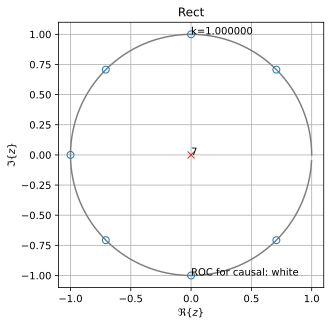

In [6]:
zplane_plot(z, p, gain, 'Rect')

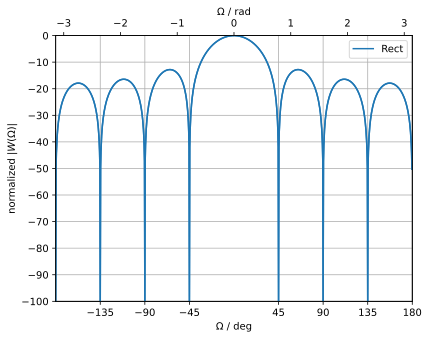

In [7]:
freq_resp(w, 'Rect')

## Symmetric Hann Window

In [8]:
# a symmetric Hann window, two zeros are not used on! the unit circle
w = (1 - np.cos(2*np.pi/N*(k+1/2))) / 2
print('my hann:', w)
[z, p, gain] = tf2zpk(w, a)

my hann: [0.03806023 0.30865828 0.69134172 0.96193977 0.96193977 0.69134172
 0.30865828 0.03806023]


In [9]:
# Note that our Hann window above differs from the numpy/scipy definitions:
# our window does start and end with a non-zero coefficient, while numpy/scipy
# versions start/end with zeros effectively using two samples less for
# signal analysis/filter design
w_tmpn = np.hanning(N)  # numpy, note: 'hanning' is an old naming to be avoided
w_tmps = hann(N)  # scipy version
w_tmp = 0.5 - 0.5 * np.cos(2*np.pi/(N-1)*(k))  # manual version
print('numpy == scipy?', np.allclose(w_tmpn, w_tmps))
print('equal to manual?', np.allclose(w_tmpn, w_tmp))
print('numpy/scipy hann:', w_tmp)

numpy == scipy? True
equal to manual? True
numpy/scipy hann: [0.         0.1882551  0.61126047 0.95048443 0.95048443 0.61126047
 0.1882551  0.        ]


In [10]:
# zeros
print('zeros: angle in deg', np.angle(z)*180/np.pi)
print('zeros: abs', np.abs(z))

zeros: angle in deg [ 180.   90.  -90.  135. -135.  180.  180.]
zeros: abs [5.51416708 1.         1.         1.         1.         1.
 0.18135105]


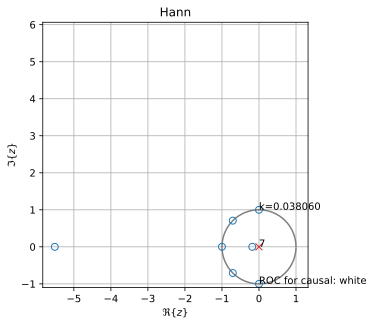

In [11]:
zplane_plot(z, p, gain, 'Hann')

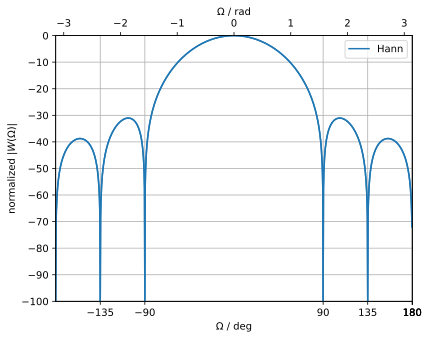

In [12]:
freq_resp(w, 'Hann')

We have two zeros that are **not** on the unit circle. If we put them **onto** the unit circle their influence with regard the DTFT (i.e. the frequency response) can be made stronger. By that we can optimize the window, for example to attenuate a certain sidelobe. This idea is pursued by the Hamming window, which is shown next.

## Symmetric Hamming Window

In [13]:
# a symmetric Hamming window
# we put notches into the two sidelobes 'left/right' of the main lobe
# of the above defined symmetric Hann window,
# thus here all zeros are used on! the unit circle
# which improves side lobe attenuation
w = 0.54 - 0.46 * np.cos(2*np.pi/N*(k+1/2))
print('my hamming:', w)
[z, p, gain] = tf2zpk(w, a)

my hamming: [0.11501542 0.36396562 0.71603438 0.96498458 0.96498458 0.71603438
 0.36396562 0.11501542]


In [14]:
# Note that our Hamming window above differs from the numpy/scipy definitions
w_tmpn = np.hamming(N)
w_tmps = hamming(N)
w_tmp = 0.54 - 0.46 * np.cos(2*np.pi/(N-1)*(k))
print('numpy == scipy?', np.allclose(w_tmpn, w_tmps))
print('equal to manual?', np.allclose(w_tmpn, w_tmp))
print('numpy/scipy hamming:', w_tmp)

numpy == scipy? True
equal to manual? True
numpy/scipy hamming: [0.08       0.25319469 0.64235963 0.95444568 0.95444568 0.64235963
 0.25319469 0.08      ]


In [15]:
# +-112.03298762 is approx +-(90 + 135) / 2
# this is the angle of the first side lobe
print('zeros-> angle in deg:', np.angle(z)*180/np.pi)
# so put a zero in the middle of the 'first/last' two zeros
# now all zeros are on! the unit circle, leading to an optimum design

# zeros
print('zeros: angle in deg', np.angle(z)*180/np.pi)
print('zeros: abs', np.abs(z))
# all zeros on! the unit circle (since all np.abs(z) == 1) 

zeros-> angle in deg: [  90.          -90.          180.          135.         -135.
  112.03298762 -112.03298762]
zeros: angle in deg [  90.          -90.          180.          135.         -135.
  112.03298762 -112.03298762]
zeros: abs [1. 1. 1. 1. 1. 1. 1.]


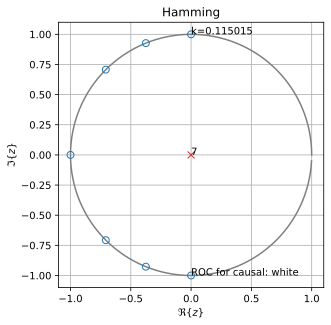

In [16]:
zplane_plot(z, p, gain, 'Hamming')

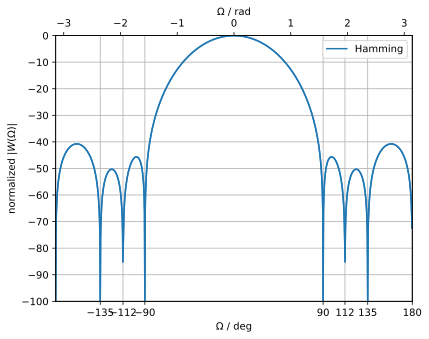

In [17]:
freq_resp(w, 'Hamming')

**Copyright**

The notebooks are provided as [Open Educational Resources](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use the notebooks for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: *Frank Schultz, Digital Signal Processing - A Tutorial Featuring Computational Examples* with the URL https://github.com/spatialaudio/digital-signal-processing-exercises